<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://raw.githubusercontent.com/Unidata/MetPy/master/src/metpy/plots/_static/unidata_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

<h1>Current weather data: coversion to point vortices plus U(y) at 500 hPa</h1>
        
<h3>Adapted from: Bonus: Using Siphon to query the NetCDF Subset Service</h3>
<h4>in Unidata Python Workshop</h4>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

Uses [MetPy](https://unidata.github.io/MetPy/latest/) and [Siphon](https://unidata.github.io/siphon/latest/) and [xarray](https://xarray.pydata.org/en/stable/index.html).

### Data from current GFS on 500mb:
* u-wind component
* absolute vorticity

### Calculations:
* Contours of smoothed vorticity (centroids ~> point vortices)
* Zonal mean U(y), eddy vorticity (avor minus its zonal mean)
* Smoothing to make number of contours tractable
* Convert those contours to GeoPandas objects, to find weighted centroid

In [249]:
%matplotlib inline  ## for plotting in notebook

from siphon.catalog import TDSCatalog
from datetime import datetime
from xarray.backends import NetCDF4DataStore
import xarray as xr
import numpy as np
from metpy.units import units

import cartopy.crs as ccrs

# Get data section

In [229]:
# Best time series is a stitched collection of analyses to present, then forecast grids in future
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/'
                      'Global_onedeg/catalog.xml?dataset=grib/NCEP/GFS/Global_onedeg/Best')
best_gfs.datasets

['Best GFS One Degree Forecast Time Series']

In [230]:
# Time zero is the latest analysis

best_ds = list(best_gfs.datasets.values())[0]
ncss = best_ds.subset()
#ncss.variables # will show all available variables

Create a query, to extract our desired variables at one level in a region

In [275]:
query = ncss.query()
query.lonlat_box(north=59, south=10, east=339, west=240).time(datetime.utcnow())
query.vertical_level(50000) # Pascals? Yes according to this example, but CAREFUL!
# https://unidata.github.io/siphon/latest/examples/ncss/NCSS_Timeseries_Examples.html?highlight=vertical
query.accept('netcdf4')
query.variables('Absolute_vorticity_isobaric')
query.variables('u-component_of_wind_isobaric')

var=Absolute_vorticity_isobaric&var=u-component_of_wind_isobaric&time=2021-08-29T19%3A50%3A04.426522&west=240&east=339&south=10&north=59&vertCoord=50000&accept=netcdf4

We now request data from the server using this query. The `NCSS` class handles parsing this NetCDF data (using the `netCDF4` module). If we print out the variable names, we see our requested variables, as well as a few others (more metadata information)

In [276]:
data = ncss.get_data(query)
data = xr.open_dataset(NetCDF4DataStore(data))

list(data)

['Absolute_vorticity_isobaric',
 'LatLon_Projection',
 'u-component_of_wind_isobaric']

In [294]:
u500 = data['u-component_of_wind_isobaric']
absvor = data['Absolute_vorticity_isobaric'].squeeze()
eddyvor = absvor - absvor.mean(dim='lon')
timestring = str(u500.time.values[0])[0:16]
timestring

'2021-08-29T21:00'

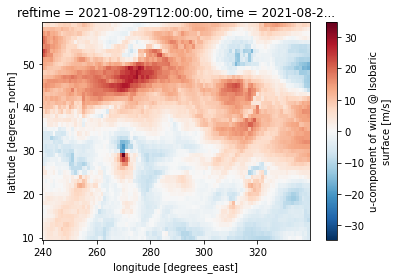

In [278]:
u500.plot()

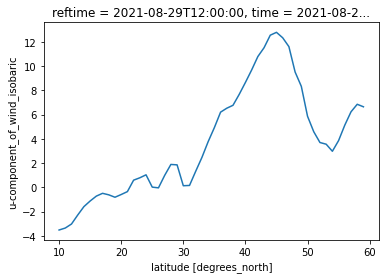

In [279]:
Ubar = u500.mean(dim='lon').squeeze()
Ubar.plot()

/anaconda3/envs/NASA/lib/python3.9/site-packages/xarray/plot/utils.py:444: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(**kwargs)


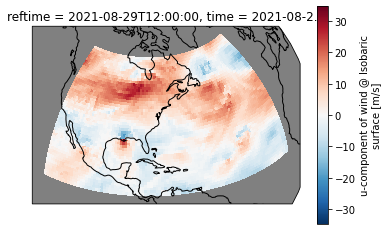

In [280]:
# With coastlines
p = u500.plot(subplot_kws=dict(projection=ccrs.Orthographic(-80, 35), facecolor="gray"), transform=ccrs.PlateCarree())
p.axes.coastlines()

Pull out the useful variables for latitude, and longitude, and time

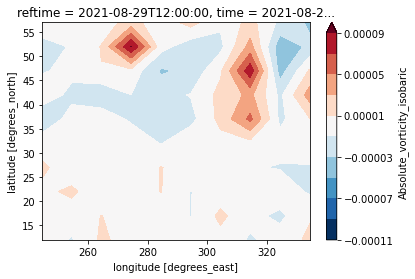

In [328]:
# integer rebinning (coarsening) 
smoothedvor = eddyvor.coarsen(lon=10).mean().coarsen(lat=5).mean()

clev_vor = np.arange(-11, 11, 2) * 1.0E-5
smoothedvor.plot.contourf(levels=clev_vor)

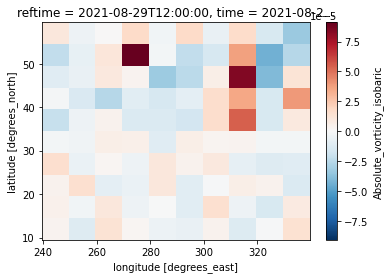

In [329]:
smoothedvor.plot()

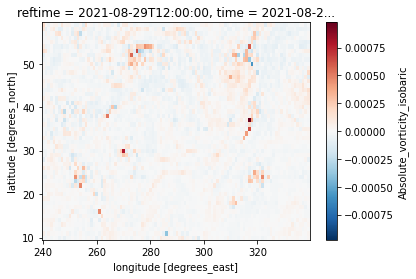

In [330]:
eddyvor.plot()

In [340]:
smoothedvor.values

array([[ 1.0468005e-05, -4.8719949e-06,  4.8004221e-08,  1.7668004e-05,
        -3.0119959e-06,  1.7648004e-05, -6.7119959e-06,  1.6768006e-05,
        -1.4331997e-05, -3.3671997e-05],
       [-2.2368000e-05, -7.5279995e-06,  1.0892001e-05,  9.0991998e-05,
        -2.6679991e-06, -2.2087999e-05, -1.5167998e-05,  3.7332000e-05,
        -4.3567994e-05, -2.5828000e-05],
       [-1.1262001e-05, -6.6220005e-06,  9.3780009e-06,  3.0779986e-06,
        -3.3181997e-05, -2.4362000e-05,  6.3580010e-06,  8.4058003e-05,
        -3.9982002e-05,  1.2538000e-05],
       [-1.5879978e-06, -1.3647997e-05, -2.6267997e-05, -1.0087997e-05,
        -1.5107997e-05, -9.1479960e-06,  1.6132002e-05,  3.4952001e-05,
        -1.4687999e-05,  3.9452003e-05],
       [-2.0933998e-05, -4.4339986e-06,  3.6860024e-06, -1.3454000e-05,
        -1.3073998e-05, -1.6473999e-05,  1.5825997e-05,  5.4526005e-05,
        -1.4293999e-05,  8.6260006e-06],
       [-2.2219992e-06, -4.1819994e-06,  5.7179996e-06,  5.4180009e-06,
   

------------------
# Point vortex solver
### seeded from entities of coarse vorticity field
### Also, add an eastward motion by Ubar(y) 
### Optionally, add a beta effect

Tangential flow falls off as $C/2 \pi r$ from a point vortex of circulation C, and we only need the velocity at the locations of all the point vortices to evolve the flow: a nice fast compuation. For display, one can reconstruct the flow field everywhere as the sum of all the point vortex-induced flows, for a visualization (streamlines or streamfunction or vectors). Simply must mask out the intense winds in the near-field of the point idealizations. 

In [5]:
#  If you are interested in the topic of point vortex motion, please read through (and cite if appropriate) our 
#  publications:
#
#  Annette Mueller, Peter Nevir, Lisa Schielicke, Mirjam Hirt, Joscha Pueltz & Isabell Sonntag (2015) Applications
#  of point vortex equilibria: blocking events and the stability of the polar vortex, Tellus A: Dynamic Meteorology 
#  and Oceanography, 67:1, DOI: 10.3402/tellusa.v67.29184 
#  https://doi.org/10.3402/tellusa.v67.29184
#
#  Mirjam Hirt, Lisa Schielicke, Annette Mueller & Peter Nevir (2018) Statistics and dynamics of blockings with a 
#  point vortex model, Tellus A: Dynamic Meteorology and Oceanography, 70:1, 1-20, DOI: 10.1080/16000870.2018.1458565
#  https://doi.org/10.1080/16000870.2018.1458565
#
#---------------------------------------------------------------------------------------------------------------------
#  created: 23 Feb 2019 (Lisa Schielicke)
#						

#---------------------------------------------------------------------------------------------------------------------
# Copyright 2019 Lisa Schielicke, contact: lisa.schielicke@met.fu-berlin.de
# Licensed under the Apache License, Version 2.0 (the "License");

In [400]:
##################
######## initial x,y-coordinates and circulations G of an N vortex system ##############################
######################################################################################################################

#x=[0.,10000,15000,20000,25000,30000,35000,5000,13000,17000,24000,33000] #in m
#y=[0.,0,0,0,0,0,0,0,0,0,0,0]                         #in m
# G=[-1.0*10**6,-0.1*10**6,0.5*10**6,1.3*10**6,-0.8*10**6,4*10**6,2*10**6,0,0,0,0,0]
#sizeofpointinplot=[10,1,5,13,8,25,16,2,2,2,2,2] # Please give a representative size, the point vortex 
                                                # should have in the plot. E.g., make the points
                                                # bigger for larger absolute circulations
lat_1d = smoothedvor['lat'].values
lon_1d = smoothedvor['lon'].values
lon_2d, lat_2d = np.meshgrid(lon_1d, lat_1d)
        
y = lat_2d.ravel() *111111.1 # meters
x = lon_2d.ravel() *111111.1 # meters, should x cos(lat)
G = smoothedvor.values.ravel()

#sizeofpointinplot = np.sqrt(np.abs(G)) * 1e5
sizeofpointinplot = np.abs(G) * 3e6

(array([ 4.,  6., 36., 32., 16.,  1.,  2.,  1.,  0.,  2.]),
 array([-4.35679940e-05, -3.01119944e-05, -1.66559948e-05, -3.19999640e-06,
         1.02560025e-05,  2.37120021e-05,  3.71679998e-05,  5.06239994e-05,
         6.40799990e-05,  7.75360022e-05,  9.09919981e-05], dtype=float32),
 <BarContainer object of 10 artists>)

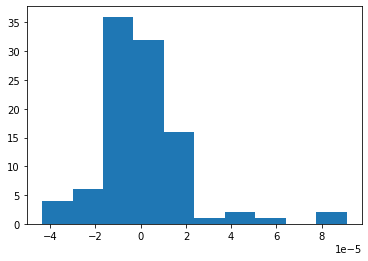

In [410]:
plt.hist(G)

In [422]:
# Set weak ones to zero (or just exclude them)
strong = abs(G)>2e-5

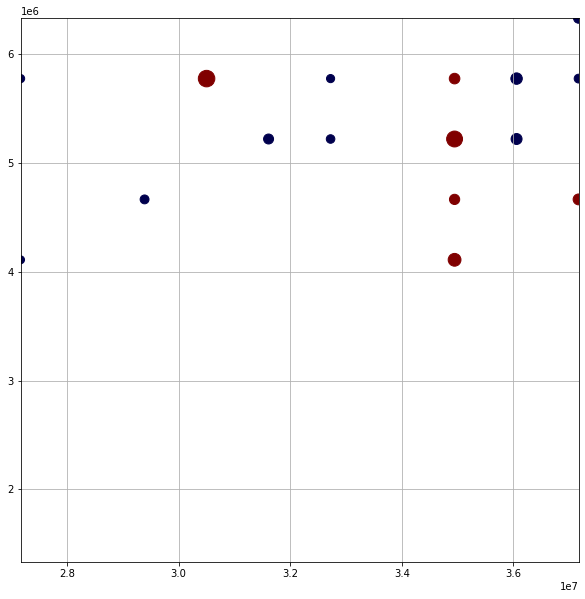

In [423]:
# Initial scatterplot 
fig = plt.figure(figsize=(10,10))
ax  = plt.subplot()   
ax.grid()
ax.set_xlim([x.min(),x.max()])
ax.set_ylim([y.min(),y.max()])

#ax.scatter(x,y,s=sizeofpointinplot, c=np.sign(G), cmap='seismic') # centered colors

ax.scatter(x[strong],y[strong],s=sizeofpointinplot[strong], 
            c=np.sign(G[strong]), cmap='seismic') # centered colors

In [424]:
# Geographic map version of the plot 
lat = y/111111.1
lon = x/111111.1

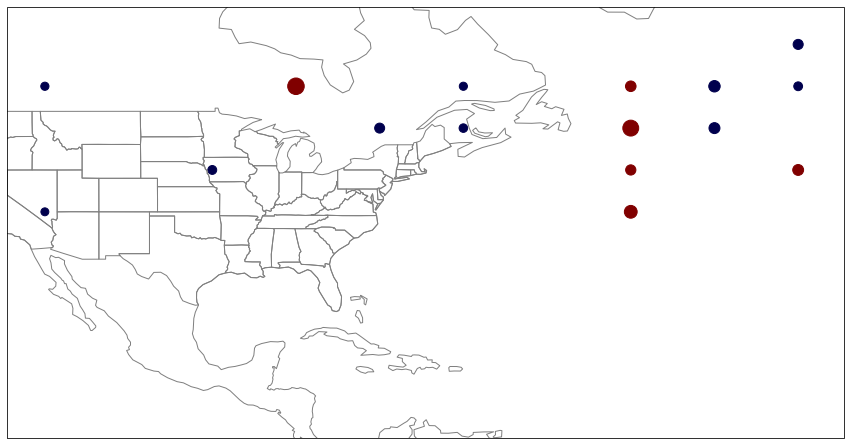

In [428]:
# Create a new figure
fig = plt.figure(figsize=(15, 12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([240, 340, 10, 50])

# Geography
ax.add_feature(cfeature.COASTLINE, edgecolor='gray')
ax.add_feature(cfeature.STATES, edgecolor='gray')

# Scatterplot vortices at each lat/lon
scat = ax.scatter(lon[strong],lat[strong],s=sizeofpointinplot[strong], 
                  c=np.sign(G[strong]), cmap='seismic')


# Solver for the point vortices 

In [350]:
# ODE solver parameters, change if necessary
abserr = 1.0e-10    # absolute error measures of the ode solver
relerr = 1.0e-10    # absolute error measures of the ode solver
stoptime = 3600*1*1 # integration time in seconds
numpoints = 300     # defines the time steps of the integration via: 
                    #    t=[stoptime*float(i)/(numpoints-1) for i in range(numpoints)]

plottitle = 'Point vortices of '+timestring #give a nice title for your plots

### pveq function updates positions of the vortices

In [25]:
def pveq(w, t, G):
##########################################################################
#  Defines the differential equations for a point vortex system of N points
#
#  Arguments:
#        w :  vector of the x,y-coordinates of each point vortex:
#                  w = [x1,y1,x2,y2]
#        t :  time
#        G :  vector of the N circulations
##########################################################################
  x = w[0::2] #    x : vector of the x-coordinates of the N point vortices
  y = w[1::2] #    y : vector of the y-coordinates of the N point vortices
#
# Create f = (x1',u1',y1',v1',x2',u2',y2',v2',...,xN',uN',yN',vN'):
  f=[]
  for j in range(0,len(G)):
    # calculate the realtive distance between point vortex j and all other point vortices
    disty=y[j]-y 
    distx=x[j]-x
    reldistsq=disty**2+distx**2
    # calculate the new coordinates (point vortex equations for [x- , y-coordinate])
    f.extend([-1/(2*np.pi)*np.sum(G[reldistsq!=0]*disty[reldistsq!=0]/(reldistsq[reldistsq!=0])),
               1/(2*np.pi)*np.sum(G[reldistsq!=0]*distx[reldistsq!=0]/(reldistsq[reldistsq!=0]))])

  return f

# The solver!

### DO ME: add other influences relevant to weather: flow not due to an interior vortex, and beta effect

1. What flow is not due to vorticity within a limited area? The mean vector averaged over that whole area, I suppose. One could just move the centroid according to that mean flow. 

2. Vortices could change their strength by converting planetary to relative vorticity, beta*y.  

In [10]:
# Create the time samples for the output of the ODE solver.
t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]
w0 = []
for i in range(0,len(G)):
  w0.append(x[i])
  w0.append(y[i])

difft=np.diff(t)[0]

# Call the ODE solver
wsol = odeint(pveq, w0, t, args=(np.asarray(G),difft),atol=abserr, rtol=relerr)

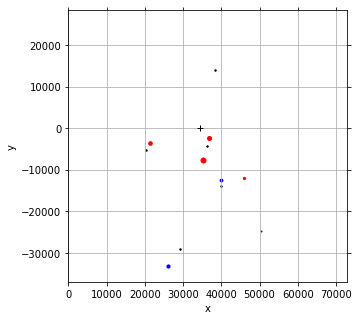

In [31]:
# create a figure and axes
fig = plt.figure(figsize=(5,5))
ax  = plt.subplot()   
ax.clear()
ax.grid()
ax.set_xlim([minx,maxx])
ax.set_ylim([miny,maxy])
ax.plot(Circcenterx,Circcentery,'k+',markersize=6)
ax.set_xlabel('x')
ax.set_ylabel('y')

# for tt in range(0,len(wsol),1):  ## was like 400 frames 

tt = 100

for k in range(0,int(len(wsol[0])/2)):
    if G[k]>0.:
      farbe='r' # plot cyclonic vortices red
    if G[k]<0.:
      farbe='b' # plot anticyclonic vortices blue
    if G[k]==0.:
      farbe='k' # plot streamers black
    ax.scatter(wsol[tt][2*k],wsol[tt][2*k+1],s=[sizeofpointinplot[k]],color=farbe)